In [1]:
import numpy as np
from darli.models import RobotModel


In [2]:
urdf_file = '../yet_another_menagerie/z1/z1.urdf'
darli_model = RobotModel(urdf_file)


In [3]:
q_des = np.array([ 7.85397669e-01,  1.39999804e+00, -1.25671438e+00,  
                   9.70957982e-01, 2.15841899e-06,  1.20044243e-01])
dq_des = np.zeros(darli_model.nv)
state_des = np.hstack((q_des, dq_des))

u_des = darli_model.gravity(q_des)

In [4]:
A = np.array(darli_model.state_space.state_jacobian(state_des, u_des))
B = np.array(darli_model.state_space.input_jacobian(state_des, u_des))

In [5]:
dt = 1/500

In [6]:
Ad, Bd = np.eye(darli_model.nq + darli_model.nv) + dt*A, dt*B

In [7]:
from scipy.linalg import solve_discrete_are as dare


def dlqr(A, B, Q, R):
    '''Discrete time LTI LQR'''
    # Solve discrete Ricatti equation (DARE)
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

In [8]:
Q = np.eye(darli_model.nq + darli_model.nv)
R = np.eye(darli_model.nu)*0.01
K, P = dlqr(Ad, Bd, Q, R)
# print(K)

In [9]:
import mujoco
import mediapy as media

%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [10]:
model = mujoco.MjModel.from_xml_path("../yet_another_menagerie/z1/scene.xml")
data = mujoco.MjData(model)
model.opt.timestep = dt

renderer = mujoco.Renderer(model)
scene_option = mujoco.MjvOption()

In [11]:
duration = 2  # (seconds)
framerate = 30 # used just for visualization

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

data.qpos = 0.7*q_des

state_history = []
control_history = []
error_history = []

while data.time < duration:
    # TODO: your control should be inserted
    q, dq = data.qpos.copy(), data.qvel.copy(),  
    state = np.hstack((q, dq))
    u =  -K @(state - state_des) + u_des
    data.ctrl = np.array(u).reshape(model.nu, )
    state_history.append(state)
    error_history.append(state - state_des)
    control_history.append(data.ctrl.copy())    

    mujoco.mj_step(model, data)

#     if len(frames) < data.time * framerate:
#         renderer.update_scene(data, scene_option=scene_option)
#         pixels = renderer.render()
#         frames.append(pixels)
    
# media.show_video(frames, fps=framerate)

In [12]:
import matplotlib.pyplot as plt

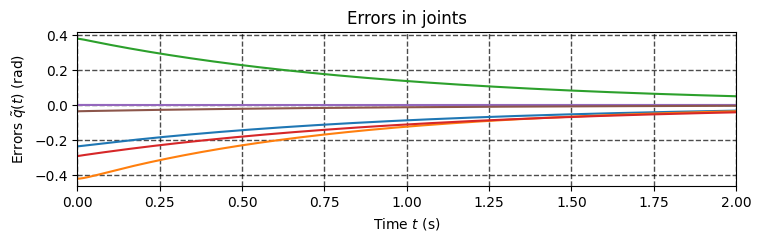

In [13]:
ns = len(state_history)
t = np.linspace(0, duration, ns)

plt.figure(figsize=(8.5, 2.))
plt.title(r'Errors in joints')
plt.plot(t, np.array(error_history)[:,:6])#,'r', linewidth=2.0)
plt.xlim([0, duration])
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Errors $\tilde{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

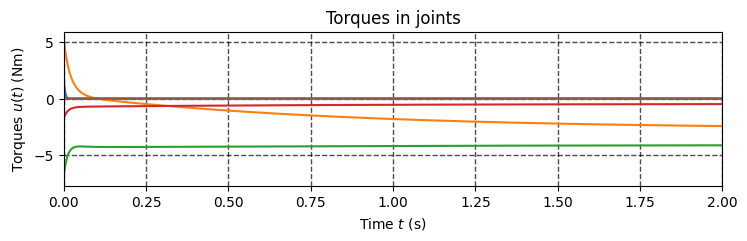

In [14]:

plt.figure(figsize=(8.5, 2.))
plt.title(r'Torques in joints')
plt.plot(t, np.array(control_history))#,'r', linewidth=2.0)
plt.xlim([0, duration])
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.ylabel(r'Torques $u(t)$ (Nm)')
plt.xlabel(r'Time $t$ (s)')
plt.show()